In [2]:
import pandas as pd
from transformer.DataAggregator import DataAggregator
from transformer.Dataformator import DataFormator
from transformer.ImputeMean import ImputeMean
from transformer.TrainTestSplit import TrainTestSplit
import utils
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import math
import statistics

from hyperopt import fmin, hp, tpe, Trials,STATUS_OK
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
# from configs.space import space
from hyperopt.pyll.base import scope

## Data Loading

In [3]:
sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")

## Data Transformation

In [4]:
data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
data_formator =DataFormator(aggregated_data,calender)
data = data_formator.format_data('store_id','dept_id')
data.index.name='date'
# impute_mean =ImputeMean(data)
# data = impute_mean.replace_zero_with_mean()
tts = TrainTestSplit( data, test_size=0.3, random_state=0,shuffle=False,stratify=None)
X_train_, X_test_, y_train_, y_test_ = tts.split_data()
y_train_.index.freq,y_test_.index.freq= 'd','d'

In [19]:
train = y_train_['CA_1_FOODS_1'].astype('float')

In [20]:
train.values

array([297., 284., 214., ..., 321., 375., 359.])

## Training for best Parameters Model tuning

### Model Tuning

In [40]:
space = {
    'p': hp.choice('p', range(0, 3)),
    'd': hp.choice('d', range(0, 3)),
    'q': hp.choice('q', range(0, 3)),
    'P': hp.choice('P', range(0, 3)),
    'D': hp.choice('D', range(0, 3)),
    'Q': hp.choice('Q', range(0, 3)),
    'seasonal_order': hp.choice('seasonal_order', [(0,0,0,0), (1,0,0,12), (0,1,0,12), (0,0,1,12), (1,1,0,12), (1,0,1,12), (0,1,1,12), (1,1,1,12)])
}

In [43]:
best ={}



for i in data.columns:
    y_train_data_ = pd.DataFrame()
    y_test_data_ = pd.DataFrame()
    y_train_data_[i] = y_train_[i].astype('float')
    y_test_data_[i] = y_test_[i].astype('float')

    def objective( params):
        sarimax_model = sm.tsa.statespace.SARIMAX(endog=y_train_data_[i], order=(params['p'], params['d'], params['q']), seasonal_order=(params['P'], params['D'], params['Q'], 12))
        sarimax_result = sarimax_model.fit()
        y_pred = sarimax_result.forecast(steps=y_test_data_.shape[0])
        mse = mean_absolute_error(y_test_data_, y_pred)
        return {'loss': mse, 'status': STATUS_OK}

    
    print(f"Training .......\n model_{i} ")

    trials = Trials()
    # optimize hyperparameters using Hyperopt's Tree-structured Parzen Estimator (TPE) algorithm
    best["best_param_{0}".format(i)] = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=3,trials=trials)

    print(best["best_param_{0}".format(i)])

Training .......
 model_CA_1_FOODS_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 3/3 [00:17<00:00,  5.82s/trial, best loss: 72.0817381067558]
{'D': 0, 'P': 2, 'Q': 1, 'd': 1, 'p': 1, 'q': 2, 'seasonal_order': 6}
Training .......
 model_CA_1_FOODS_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:01<00:02,  1.46s/trial, best loss: 140.99803744170333]

 67%|██████▋   | 2/3 [00:05<00:02,  2.93s/trial, best loss: 132.48850529503085]

100%|██████████| 3/3 [00:05<00:00,  1.98s/trial, best loss: 132.48850529503085]
{'D': 2, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 2, 'seasonal_order': 0}
Training .......
 model_CA_1_FOODS_3 
100%|██████████| 3/3 [00:06<00:00,  2.26s/trial, best loss: 530.6613036151059]
{'D': 1, 'P': 1, 'Q': 0, 'd': 0, 'p': 1, 'q': 1, 'seasonal_order': 7}
Training .......
 model_CA_1_HOBBIES_1 
 33%|███▎      | 1/3 [00:00<00:00,  2.67trial/s, best loss: 284310.8983424386]

100%|██████████| 3/3 [00:10<00:00,  3.54s/trial, best loss: 84.62399823103513]
{'D': 0, 'P': 2, 'Q': 2, 'd': 0, 'p': 0, 'q': 1, 'seasonal_order': 2}
Training .......
 model_CA_1_HOBBIES_2 
100%|██████████| 3/3 [00:04<00:00,  1.35s/trial, best loss: 14.458840802861207]
{'D': 1, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 2, 'seasonal_order': 2}
Training .......
 model_CA_1_HOUSEHOLD_1 
100%|██████████| 3/3 [00:09<00:00,  3.17s/trial, best loss: 161.91924013600342]
{'D': 1, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 0, 'seasonal_order': 5}
Training .......
 model_CA_1_HOUSEHOLD_2 
100%|██████████| 3/3 [00:03<00:00,  1.12s/trial, best loss: 45.07852627234246]
{'D': 0, 'P': 0, 'Q': 2, 'd': 1, 'p': 0, 'q': 0, 'seasonal_order': 4}
Training .......
 model_CA_2_FOODS_1 
 67%|██████▋   | 2/3 [00:14<00:06,  6.46s/trial, best loss: 99.0053712951549]  

100%|██████████| 3/3 [00:16<00:00,  5.41s/trial, best loss: 97.11860276750191]
{'D': 0, 'P': 0, 'Q': 1, 'd': 0, 'p': 2, 'q': 2, 'seasonal_order': 7}
Training .......
 model_CA_2_FOODS_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:01<00:03,  1.53s/trial, best loss: 164.86312264484584]

 67%|██████▋   | 2/3 [00:27<00:15, 15.70s/trial, best loss: 164.86312264484584]

100%|██████████| 3/3 [00:33<00:00, 11.10s/trial, best loss: 164.86312264484584]
{'D': 1, 'P': 2, 'Q': 0, 'd': 2, 'p': 0, 'q': 1, 'seasonal_order': 0}
Training .......
 model_CA_2_FOODS_3 
 33%|███▎      | 1/3 [00:01<00:02,  1.00s/trial, best loss: 20420.49193714396]

100%|██████████| 3/3 [00:06<00:00,  2.06s/trial, best loss: 409.35436614799016]
{'D': 0, 'P': 0, 'Q': 0, 'd': 2, 'p': 0, 'q': 1, 'seasonal_order': 4}
Training .......
 model_CA_2_HOBBIES_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:18<00:36, 18.32s/trial, best loss: 123.91231083038761]

100%|██████████| 3/3 [00:25<00:00,  8.46s/trial, best loss: 123.91231083038761]
{'D': 2, 'P': 2, 'Q': 1, 'd': 0, 'p': 1, 'q': 2, 'seasonal_order': 2}
Training .......
 model_CA_2_HOBBIES_2 
 33%|███▎      | 1/3 [00:04<00:08,  4.25s/trial, best loss: 14.603281871154197]

 67%|██████▋   | 2/3 [00:17<00:09,  9.50s/trial, best loss: 14.603281871154197]

100%|██████████| 3/3 [00:23<00:00,  7.94s/trial, best loss: 14.603281871154197]
{'D': 1, 'P': 2, 'Q': 1, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 6}
Training .......
 model_CA_2_HOUSEHOLD_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:17<00:34, 17.01s/trial, best loss: 176.76936088858685]

100%|██████████| 3/3 [00:26<00:00,  8.97s/trial, best loss: 176.76936088858685]
{'D': 2, 'P': 1, 'Q': 2, 'd': 0, 'p': 2, 'q': 0, 'seasonal_order': 7}
Training .......
 model_CA_2_HOUSEHOLD_2 
100%|██████████| 3/3 [00:15<00:00,  5.27s/trial, best loss: 70.67909934298297]
{'D': 1, 'P': 0, 'Q': 1, 'd': 0, 'p': 2, 'q': 0, 'seasonal_order': 0}
Training .......
 model_CA_3_FOODS_1 
 33%|███▎      | 1/3 [00:00<00:01,  1.79trial/s, best loss: 87.70283239982086]

100%|██████████| 3/3 [00:10<00:00,  3.45s/trial, best loss: 77.35560161099293]
{'D': 0, 'P': 1, 'Q': 0, 'd': 0, 'p': 1, 'q': 2, 'seasonal_order': 2}
Training .......
 model_CA_3_FOODS_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:05<00:11,  5.57s/trial, best loss: 93.40810606330243]

 67%|██████▋   | 2/3 [00:16<00:08,  8.81s/trial, best loss: 93.40810606330243]

100%|██████████| 3/3 [00:18<00:00,  6.30s/trial, best loss: 93.40810606330243]
{'D': 0, 'P': 2, 'Q': 2, 'd': 1, 'p': 2, 'q': 2, 'seasonal_order': 2}
Training .......
 model_CA_3_FOODS_3 
 33%|███▎      | 1/3 [00:06<00:12,  6.39s/trial, best loss: 114744.79779341872]

100%|██████████| 3/3 [00:08<00:00,  2.88s/trial, best loss: 927.9852556425175] 
{'D': 0, 'P': 0, 'Q': 1, 'd': 1, 'p': 2, 'q': 2, 'seasonal_order': 1}
Training .......
 model_CA_3_HOBBIES_1 
 33%|███▎      | 1/3 [00:01<00:02,  1.33s/trial, best loss: 95.1652515396912]

100%|██████████| 3/3 [00:07<00:00,  2.62s/trial, best loss: 95.1652515396912]
{'D': 0, 'P': 2, 'Q': 0, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 7}
Training .......
 model_CA_3_HOBBIES_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 3/3 [00:45<00:00, 15.30s/trial, best loss: 27.321452720591513]
{'D': 0, 'P': 2, 'Q': 0, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 5}
Training .......
 model_CA_3_HOUSEHOLD_1 
100%|██████████| 3/3 [00:06<00:00,  2.07s/trial, best loss: 313.62118394179544]
{'D': 2, 'P': 1, 'Q': 1, 'd': 1, 'p': 2, 'q': 1, 'seasonal_order': 3}
Training .......
 model_CA_3_HOUSEHOLD_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:18<00:36, 18.11s/trial, best loss: 81.12727898276418]

100%|██████████| 3/3 [00:40<00:00, 13.50s/trial, best loss: 69.21051329626508]
{'D': 1, 'P': 2, 'Q': 2, 'd': 2, 'p': 0, 'q': 2, 'seasonal_order': 7}
Training .......
 model_CA_4_FOODS_1 
 33%|███▎      | 1/3 [00:00<00:01,  1.09trial/s, best loss: 38.00453393528414]

100%|██████████| 3/3 [00:14<00:00,  4.75s/trial, best loss: 38.00453393528414]
{'D': 1, 'P': 2, 'Q': 0, 'd': 0, 'p': 1, 'q': 0, 'seasonal_order': 6}
Training .......
 model_CA_4_FOODS_2 
100%|██████████| 3/3 [00:10<00:00,  3.58s/trial, best loss: 71.36286795893687] 
{'D': 1, 'P': 1, 'Q': 2, 'd': 0, 'p': 2, 'q': 0, 'seasonal_order': 2}
Training .......
 model_CA_4_FOODS_3 
 33%|███▎      | 1/3 [00:03<00:07,  3.78s/trial, best loss: 305.95375671416264]

100%|██████████| 3/3 [00:20<00:00,  6.91s/trial, best loss: 303.8274839305998] 
{'D': 0, 'P': 1, 'Q': 0, 'd': 1, 'p': 0, 'q': 0, 'seasonal_order': 2}
Training .......
 model_CA_4_HOBBIES_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:18<00:36, 18.42s/trial, best loss: 66.86792023668052]

100%|██████████| 3/3 [00:28<00:00,  9.40s/trial, best loss: 66.86792023668052]
{'D': 2, 'P': 0, 'Q': 2, 'd': 0, 'p': 1, 'q': 2, 'seasonal_order': 5}
Training .......
 model_CA_4_HOBBIES_2 
100%|██████████| 3/3 [00:01<00:00,  1.55trial/s, best loss: 8.416283600820497]
{'D': 1, 'P': 1, 'Q': 0, 'd': 0, 'p': 0, 'q': 1, 'seasonal_order': 1}
Training .......
 model_CA_4_HOUSEHOLD_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 3/3 [00:04<00:00,  1.47s/trial, best loss: 51.685001059764296]
{'D': 1, 'P': 2, 'Q': 1, 'd': 0, 'p': 2, 'q': 0, 'seasonal_order': 0}
Training .......
 model_CA_4_HOUSEHOLD_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 67%|██████▋   | 2/3 [00:07<00:03,  3.36s/trial, best loss: 18.356269919054288]

100%|██████████| 3/3 [00:07<00:00,  2.65s/trial, best loss: 18.356269919054288]
{'D': 0, 'P': 1, 'Q': 2, 'd': 0, 'p': 2, 'q': 2, 'seasonal_order': 6}
Training .......
 model_TX_1_FOODS_1 
100%|██████████| 3/3 [00:10<00:00,  3.52s/trial, best loss: 44.227934678927994]
{'D': 0, 'P': 1, 'Q': 1, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 2}
Training .......
 model_TX_1_FOODS_2 
 33%|███▎      | 1/3 [00:08<00:16,  8.16s/trial, best loss: 666.187256248635]

100%|██████████| 3/3 [00:42<00:00, 14.08s/trial, best loss: 69.64011959244004]
{'D': 2, 'P': 2, 'Q': 1, 'd': 0, 'p': 2, 'q': 2, 'seasonal_order': 4}
Training .......
 model_TX_1_FOODS_3 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 3/3 [00:22<00:00,  7.56s/trial, best loss: 290.6242015103671]
{'D': 1, 'P': 2, 'Q': 0, 'd': 1, 'p': 1, 'q': 1, 'seasonal_order': 6}
Training .......
 model_TX_1_HOBBIES_1 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 67%|██████▋   | 2/3 [00:15<00:06,  6.48s/trial, best loss: 56.96029854073836]

100%|██████████| 3/3 [00:20<00:00,  6.95s/trial, best loss: 56.96029854073836]
{'D': 0, 'P': 0, 'Q': 0, 'd': 1, 'p': 0, 'q': 2, 'seasonal_order': 7}
Training .......
 model_TX_1_HOBBIES_2 
100%|██████████| 3/3 [00:05<00:00,  1.75s/trial, best loss: 17.775665675987074]
{'D': 1, 'P': 2, 'Q': 2, 'd': 0, 'p': 1, 'q': 2, 'seasonal_order': 4}
Training .......
 model_TX_1_HOUSEHOLD_1 
 33%|███▎      | 1/3 [00:01<00:02,  1.19s/trial, best loss: 116.65494092918468]

 67%|██████▋   | 2/3 [00:03<00:02,  2.01s/trial, best loss: 116.65494092918468]

100%|██████████| 3/3 [00:04<00:00,  1.56s/trial, best loss: 116.65494092918468]
{'D': 0, 'P': 2, 'Q': 0, 'd': 2, 'p': 0, 'q': 1, 'seasonal_order': 3}
Training .......
 model_TX_1_HOUSEHOLD_2 
100%|██████████| 3/3 [00:01<00:00,  1.82trial/s, best loss: 29.508601226838056]
{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 0, 'seasonal_order': 7}
Training .......
 model_TX_2_FOODS_1 
100%|██████████| 3/3 [00:04<00:00,  1.47s/trial, best loss: 44.85660855244423]
{'D': 1, 'P': 1, 'Q': 1, 'd': 0, 'p': 2, 'q': 0, 'seasonal_order': 7}
Training .......
 model_TX_2_FOODS_2 
100%|██████████| 3/3 [00:21<00:00,  7.04s/trial, best loss: 71.95417512007643]
{'D': 1, 'P': 0, 'Q': 2, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 4}
Training .......
 model_TX_2_FOODS_3 
100%|██████████| 3/3 [00:05<00:00,  1.70s/trial, best loss: 467.8759407221494]
{'D': 1, 'P': 2, 'Q': 1, 'd': 1, 'p': 1, 'q': 0, 'seasonal_order': 2}
Training .......
 model_TX_2_HOBBIES_1 
 33%|███▎      | 1/3 [00:00<00:00,  4.23trial/s, best los

100%|██████████| 3/3 [00:01<00:00,  1.57trial/s, best loss: 72.69433182755068]
{'D': 0, 'P': 0, 'Q': 0, 'd': 1, 'p': 1, 'q': 1, 'seasonal_order': 3}
Training .......
 model_TX_2_HOBBIES_2 
100%|██████████| 3/3 [00:04<00:00,  1.65s/trial, best loss: 15.942573786716656]

100%|██████████| 3/3 [00:04<00:00,  1.35s/trial, best loss: 15.942573786716656]
{'D': 0, 'P': 1, 'Q': 2, 'd': 1, 'p': 2, 'q': 2, 'seasonal_order': 0}
Training .......
 model_TX_2_HOUSEHOLD_1 
100%|██████████| 3/3 [00:03<00:00,  1.28s/trial, best loss: 132.1735707404608]
{'D': 0, 'P': 1, 'Q': 2, 'd': 2, 'p': 0, 'q': 1, 'seasonal_order': 2}
Training .......
 model_TX_2_HOUSEHOLD_2 
100%|██████████| 3/3 [00:16<00:00,  5.46s/trial, best loss: 35.27678423278795]
{'D': 0, 'P': 1, 'Q': 2, 'd': 1, 'p': 2, 'q': 0, 'seasonal_order': 7}
Training .......
 model_TX_3_FOODS_1 
 67%|██████▋   | 2/3 [00:04<00:02,  2.21s/trial, best loss: 132.2201322015423]

100%|██████████| 3/3 [00:11<00:00,  3.92s/trial, best loss: 77.75186886982141]
{'D': 1, 'P': 2, 'Q': 2, 'd': 0, 'p': 2, 'q': 1, 'seasonal_order': 2}
Training .......
 model_TX_3_FOODS_2 
100%|██████████| 3/3 [00:05<00:00,  1.72s/trial, best loss: 80.56715847727226]
{'D': 1, 'P': 0, 'Q': 1, 'd': 2, 'p': 0, 'q': 2, 'seasonal_order': 2}
Training .......
 model_TX_3_FOODS_3 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:03<00:06,  3.38s/trial, best loss: 311.978442041179]

100%|██████████| 3/3 [00:33<00:00, 11.30s/trial, best loss: 311.978442041179]
{'D': 1, 'P': 0, 'Q': 1, 'd': 1, 'p': 2, 'q': 2, 'seasonal_order': 5}
Training .......
 model_TX_3_HOBBIES_1 
 33%|███▎      | 1/3 [00:04<00:08,  4.15s/trial, best loss: 93.89377048921037]

 67%|██████▋   | 2/3 [00:05<00:02,  2.50s/trial, best loss: 83.9663917693174] 

100%|██████████| 3/3 [00:13<00:00,  4.48s/trial, best loss: 72.22535571254615]
{'D': 1, 'P': 2, 'Q': 2, 'd': 0, 'p': 2, 'q': 1, 'seasonal_order': 2}
Training .......
 model_TX_3_HOBBIES_2 
 33%|███▎      | 1/3 [00:00<00:01,  1.39trial/s, best loss: 17.646347662099743]

 67%|██████▋   | 2/3 [00:24<00:14, 14.26s/trial, best loss: 17.646347662099743]

100%|██████████| 3/3 [00:27<00:00,  9.23s/trial, best loss: 17.646347662099743]
{'D': 0, 'P': 0, 'Q': 0, 'd': 2, 'p': 0, 'q': 2, 'seasonal_order': 6}
Training .......
 model_TX_3_HOUSEHOLD_1 
100%|██████████| 3/3 [00:19<00:00,  6.39s/trial, best loss: 128.896624353389]
{'D': 2, 'P': 0, 'Q': 2, 'd': 2, 'p': 1, 'q': 1, 'seasonal_order': 6}
Training .......
 model_TX_3_HOUSEHOLD_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:03<00:06,  3.44s/trial, best loss: 39.32659916529277]

100%|██████████| 3/3 [00:09<00:00,  3.20s/trial, best loss: 28.49446791801065]
{'D': 0, 'P': 1, 'Q': 2, 'd': 2, 'p': 1, 'q': 2, 'seasonal_order': 3}
Training .......
 model_WI_1_FOODS_1 
100%|██████████| 3/3 [00:08<00:00,  2.79s/trial, best loss: 61.58225524946826]
{'D': 1, 'P': 1, 'Q': 2, 'd': 1, 'p': 1, 'q': 2, 'seasonal_order': 6}
Training .......
 model_WI_1_FOODS_2 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 67%|██████▋   | 2/3 [00:08<00:03,  3.80s/trial, best loss: 124.76520327745239]

100%|██████████| 3/3 [00:10<00:00,  3.37s/trial, best loss: 124.76520327745239]
{'D': 1, 'P': 0, 'Q': 1, 'd': 1, 'p': 2, 'q': 0, 'seasonal_order': 3}
Training .......
 model_WI_1_FOODS_3 
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

 33%|███▎      | 1/3 [00:03<00:06,  3.47s/trial, best loss: 5665.752104751527]

100%|██████████| 3/3 [00:09<00:00,  3.00s/trial, best loss: 301.1696918561518]
{'D': 0, 'P': 1, 'Q': 2, 'd': 0, 'p': 2, 'q': 2, 'seasonal_order': 6}
Training .......
 model_WI_1_HOBBIES_1 
100%|██████████| 3/3 [00:21<00:00,  7.29s/trial, best loss: 93.5019579315736]  
{'D': 1, 'P': 0, 'Q': 2, 'd': 0, 'p': 1, 'q': 1, 'seasonal_order': 4}
Training .......
 model_WI_1_HOBBIES_2 
 33%|███▎      | 1/3 [00:00<00:01,  1.20trial/s, best loss: 36.633677582351325]


job exception: LU decomposition error.



 33%|███▎      | 1/3 [00:20<00:40, 20.21s/trial, best loss: 36.633677582351325]


LinAlgError: LU decomposition error.

### Save Best parameters

In [44]:
utils.save_to_json('sarimax_best_params',best,'w')

## Training with best parameters Model Training

### Reading Best Parameters

In [5]:
best =utils.read_from_json('sarimax_best_params',mode="r")
best.keys()

dict_keys(['best_param_CA_1_FOODS_1', 'best_param_CA_1_FOODS_2', 'best_param_CA_1_FOODS_3', 'best_param_CA_1_HOBBIES_1', 'best_param_CA_1_HOBBIES_2', 'best_param_CA_1_HOUSEHOLD_1', 'best_param_CA_1_HOUSEHOLD_2', 'best_param_CA_2_FOODS_1', 'best_param_CA_2_FOODS_2', 'best_param_CA_2_FOODS_3', 'best_param_CA_2_HOBBIES_1', 'best_param_CA_2_HOBBIES_2', 'best_param_CA_2_HOUSEHOLD_1', 'best_param_CA_2_HOUSEHOLD_2', 'best_param_CA_3_FOODS_1', 'best_param_CA_3_FOODS_2', 'best_param_CA_3_FOODS_3', 'best_param_CA_3_HOBBIES_1', 'best_param_CA_3_HOBBIES_2', 'best_param_CA_3_HOUSEHOLD_1', 'best_param_CA_3_HOUSEHOLD_2', 'best_param_CA_4_FOODS_1', 'best_param_CA_4_FOODS_2', 'best_param_CA_4_FOODS_3', 'best_param_CA_4_HOBBIES_1', 'best_param_CA_4_HOBBIES_2', 'best_param_CA_4_HOUSEHOLD_1', 'best_param_CA_4_HOUSEHOLD_2', 'best_param_TX_1_FOODS_1', 'best_param_TX_1_FOODS_2', 'best_param_TX_1_FOODS_3', 'best_param_TX_1_HOBBIES_1', 'best_param_TX_1_HOBBIES_2', 'best_param_TX_1_HOUSEHOLD_1', 'best_param_TX_

### Model Training

In [21]:
trained_model={}
j=0;
for i in data.columns:
    if j==3:
        break;
    j+=1;

    y_train_data_ = pd.DataFrame()
    y_train_data_[i] = data[i].astype('float')
    
    order = (best[f"best_param_{i}"]['p'], best[f"best_param_{i}"]['d'], best[f"best_param_{i}"]['q'])
    seasonal_order = (best[f"best_param_{i}"]['P'], best[f"best_param_{i}"]['D'], best[f"best_param_{i}"]['Q'], 12)
    model = sm.tsa.statespace.SARIMAX(
        y_train_data_[i],
        order=order,
        seasonal_order=seasonal_order
    )
    print(f"Traning model_{i} ........")
    trained_model["model_{0}".format(i)] =model.fit()
    

In [14]:
model = trained_model['model_CA_1_FOODS_1']


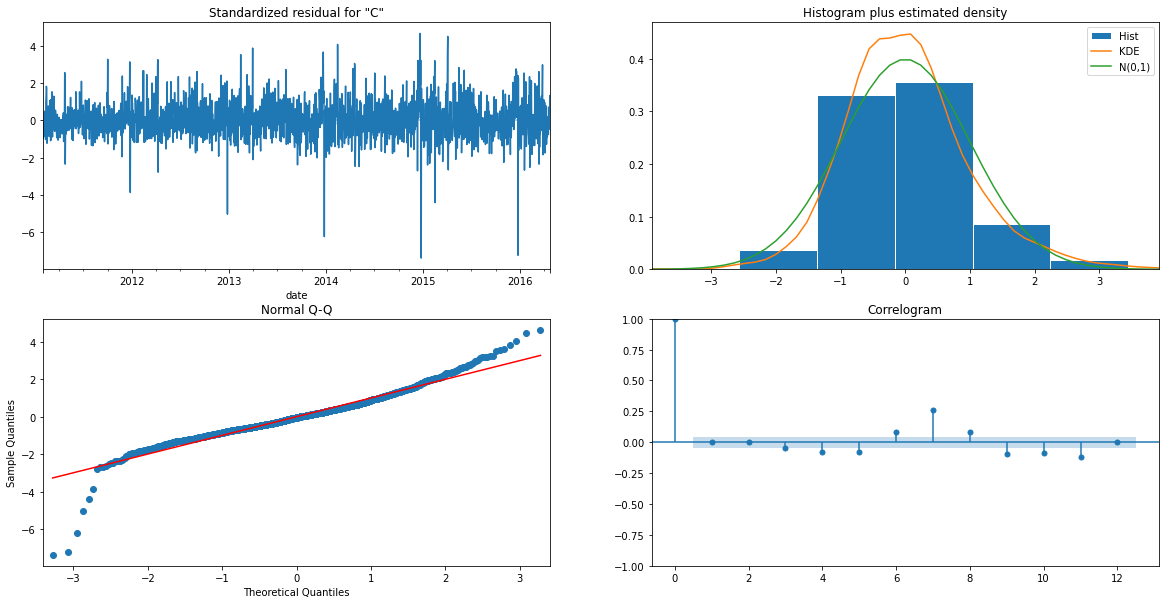

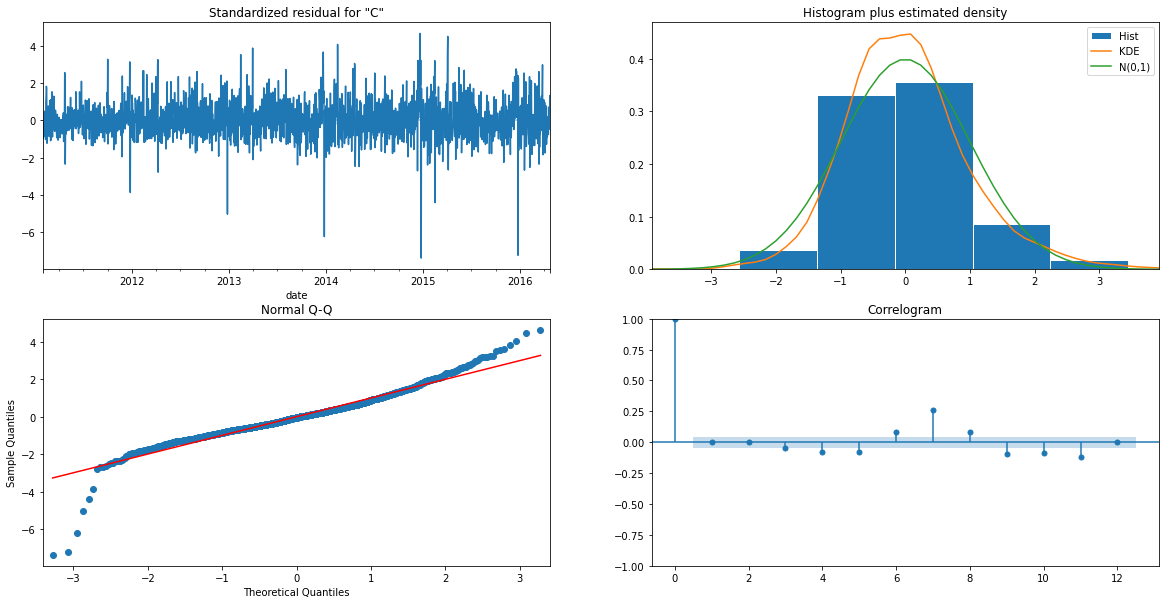

In [15]:
model.plot_diagnostics(lags=12,figsize = (20,10),)

# Generate forcaste

In [9]:
model = trained_model['model_CA_1_FOODS_1']

In [10]:
y_test_data_.shape[0]

574

In [17]:
forecast = model.forecast(steps=100)
forecast

2016-04-25    319.641567
2016-04-26    311.474405
2016-04-27    300.452343
2016-04-28    322.650536
2016-04-29    327.976807
                 ...    
2016-07-29    308.768760
2016-07-30    308.793797
2016-07-31    308.759077
2016-08-01    308.776144
2016-08-02    308.705811
Freq: D, Name: predicted_mean, Length: 100, dtype: float64